# Introduction
In this exercise you'll implement a fully-connected neural network and the computations necessary for the backpropagation algorithm to optimize its parameters. Before starting on the programming exercise, we strongly recommend watching the video lectures and going over the theoretical exercise sheet first. All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

CAUTION: You need python version >= 3.4!

## Grading

**Required Exercises**

| Section | Part                                          |Submitted Function                     | Points 
|---------|:-                                             |:-                                     | :-:    
| 1       | [Implementing a Fully-Connected Neural Net](#fcnn) | [`affine_forward`](#affine_forward)    |  5  
|         |                                               | [`relu_forward`](#relu_forward) |  5
|         |                                               | [`relu_backward`](#relu_backward) |  5
|         |                                               | [`affine_backward`](#affine_backward) |  15
| 2       | [Softmax classifier](#Softmax_classifier)     | [`cross_entropy_loss`](#cross_entropy_loss) |  20
|         |                                               | [`TwoLayerNet`](#TwoLayerNet) |  20
| 3       | [Qualitative Analysis](#Qualitative_Analysis)     | [`50_best`](#50_best) |  10
|         |                                               | [`50_worst`](#50_worst) |  10
|         |                                               | [`q3`](#q3) |  5
|         |                                               | [`q4`](#q4) |  5
|         | Total Points                                  |                                       | 100


## Google Colab

Colaboratory, or "Colab" for short, allows you to write and execute Python notebooks in your browser, with 
- close to zero configuration required
- Free access to GPUs (Nvidia Tesla K80)
- Easy sharing and collaborative work on a single file.

Just like local python notebooks, this file consists of (markdown) text cells and python code cells. You can add and delete cells and move them around in this document. You can change the runtime type from CPU to GPU (`Runtime-> Change runtime type -> Hardware Accelerator -> GPU`) to speed up your computations when using a GPU-capable machine learning library. You can import your python libraries, load data from the web and even install new libraries on the virtual machine by typing `!pip install <libraryname>` , the exclamation mark lets you escape the python environment and type on the commandline. 

**Requirements** To use Colab, you must have a Google account with an associated Google Drive.

**Workflow** For the assignments, you can keep on working locally with the python notebooks that we provide for the practical. But we recommend to use colab, because it offers a nice way of working together as a group on the practical assignments. Furthermore the free GPU will be useful for future assignments that require more computational ressources. 

**Limitations** Ressources on colab are not guaranteed and therefore there might be times where some ressources cannot get allocated. If you're idle for 90 minutes or your connection time exceeds the maximum of 12 hours, the colab virtual machine will disconnect. This means that unsaved progress such as model parameters are lost. 

**Assignment submission** Just download the notebook at `File->Download .ipynb` and hand it in as usual. 

<a id="Image_classification"></a>
## Image classification
The task for this practical is to build a multi-class image classification model. The dataset we'll work with is the CIFAR10 image classification benchmark. It consists of 50,000 training images (each in $32 \times 32$ resolution with RGB color channels). Each pixel is represented as three floating point numbers, indicating the color intensity in the respective color channel. Each image is labeled with integers ranging from 0 to 9 (0-9), indicating the class of the image content. The 10 classes and according example images from the dataset are shown in the image below. The dataset also consists of a test dataset, that consists of another 10,000 images and their labels. 

![Cifar10](https://pytorch.org/tutorials/_images/cifar10.png)

We further split the training images into 45,000 training samples and 5,000 validation samples. The network will just be trained on the training dataset and we use the validation data to check during training if the network generalizes well to new data. In future assignments, the validation dataset is used to tweak the hyperparameters of the model. The test data is not used until the very end of the process, to evaluate the models generalization ability on prior unseen data (which serves as a proxy for deploying the model in the real world).  

You can load the complete dataset into memory by just running the next cell. 
For loading the dataset, we used a convenience function from the package `tensorflow`. On colab, this package is already installed, on your local machine you might have to install it first. You can install tensorflow via pip or via Anaconda (which is often easier). However you don't need to install it: you can also just download the data [here](https://www.cs.toronto.edu/~kriz/cifar.html) and edit the function `get_CIFAR10_data` below. In this case, make sure that the function returns the data in these dimensions:

```python
('X_train: ', (45000, 3, 32, 32))
('y_train: ', (45000,))
('X_val: ', (5000, 3, 32, 32))
('y_val: ', (5000,))
('X_test: ', (10000, 3, 32, 32))
('y_test: ', (10000,))
```

In [1]:
# load utils for this practical
from utils import *
import matplotlib.pyplot as plt
from builtins import range
from builtins import object

#Load CIFAR10 data
from tensorflow.keras.datasets import cifar10
import numpy as np

def get_CIFAR10_data(
    num_training=45000, num_validation=5000, num_test=10000, subtract_mean=True
):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    (train, test) = cifar10.load_data()
    X_train, y_train = train
    X_train = X_train.astype(np.float32)
    X_test, y_test = test
    X_test = X_test.astype(np.float32)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": np.squeeze(y_train),
        "X_val": X_val,
        "y_val": np.squeeze(y_val),
        "X_test": X_test,
        "y_test": np.squeeze(y_test),
    }

# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

2024-05-06 19:48:29.459406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 19:48:30.016710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


('X_train: ', (45000, 3, 32, 32))
('y_train: ', (45000,))
('X_val: ', (5000, 3, 32, 32))
('y_val: ', (5000,))
('X_test: ', (10000, 3, 32, 32))
('y_test: ', (10000,))


<a id="fcnn"></a>
# 1. Implementing a Fully-Connected Neural Net
We want to implement a neural network with at least one hidden layer, like the one below. It has 2 layers besides the input layer - , a hidden layer and an output layer. 

## 1.1 Forward pass
![Network architecture](https://i.imgur.com/yv1FR86.png)  

The forward pass of the network is denoted in green. Recall that our inputs are pixel values of RGB images. Since the images are of size $32 \times 32 \times 3$, this gives us 3072 input features for the first layer. Therefore, the weight vector of a single neuron $j$ in layler 2 ( $w^{(1)}_j)$ has 3072 values and a single bias $b^{(1)}_j$. By applying the activation function $g(.)$ on the pre-activations $z^{(2)}$, we get the activations of the hidden layer $a^{(2)}=g(z^{(2)})$. The same applies for the output layer which takes the activations of the preceeding layer $a^{(2)}$ as the input, weights with $w^{(2)}$, adds bias $b^{(2)}$ and uses the activation function to arrive at $a^{(3)}$. The number of neurons in the output layer corresponds to the number of classes in the classification problem, so for CIFAR10 it'll be 10 output neurons. In our case $a^{(3)}$ holds the logits of the hypothesis $h_\theta(x)$. These will be used in a loss function $L_\theta$ to assess the predictions of the model.

### 1.1.1 Affine layer: forward
Now please implement the function `affine forward` below, which calculates pre-activations $z^{(l)} = w^{(l-1)}x + b^{(l)}$  and test your implementation with the provided test cases.
<a id="affine_forward"></a>

In [2]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x2 = x.reshape(x.shape[0], np.prod(x.shape[1:]))
    out = np.dot(x2, w) + b
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache


In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)

weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


### 1.1.2 ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation. The ReLU activation function is just $g(z) =  \begin{cases}
    z, & \text{for } z > 0 \\
    0, & \text{for } z \leq 0 \\
  \end{cases}$
<a id="relu_forward"></a>

In [4]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out = (x > 0) * x

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


## 1.2 Backward pass
The backward pass of the network is denoted in red. The general idea of the backpropagation of errors algorithm is to calculate partial derivatives of the loss $L_\theta$ with respect to the (pre-)activations of every layer in the network. Then the gradient descent algorithm is used to calculate the partial derivatives of the pre-activations with respect to the weights and biases.  

![Network architecture](https://i.imgur.com/SHe3l14.png) 

This procedure starts with the derivative of the loss with respect to the hypothesis $h_\theta(x)=a^{(3)}$, so $\frac{\partial L_{\theta}}{\partial a^{(3)}}$, which will be calculated by the function `cross_entropy_loss`. Then the derivative of the activation function $\frac{\partial a^{(l)}}{z^{(l)}}$ with respect to the pre-activations is calculated by the function `relu_backward` and we get $\delta^{(l)}=\frac{\partial L_{\theta}} {\partial a^{(l)}}\frac{\partial a^{(l)}}{z^{(l)}}$. Finally, the function `affine_backward` computes the derivatives `dw`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial w^{(l-1)}}$, `db`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b^{(l-1)}}$ and `dx`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial a^{(l-1)}}$, which are needed to update the parameters of the model. 

Hint: When figuring out the derivatives needed for the back-propagation algorithm, you can always think about them in terms of the circuit notation used in the stanford cs231n course to check if they are plausible to you:

![Circuit](https://i.imgur.com/YN6z5gK.png)



### 1.2.1 ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using gradient checking.
<a id="relu_backward"></a>

In [5]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = (x > 0) * dout

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


### Small excursion: Numeric gradient checking
Numeric gradient checking calculates a numerical approximation of the gradient by adding and substracting a small $\epsilon$ from the variable of interest. When we want to check the gradient of the weights $\theta$, we assume

$ \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\  \vdots \\ \epsilon \\ \vdots \\  0 \end{bmatrix}$ and $ \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\  \vdots \\ \epsilon \\ \vdots \\  0 \end{bmatrix}$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $\frac{\partial L_{\theta}}{\partial \theta}$’s correctness by checking, for each $i$, that:

$$ \frac{\partial L_{\theta}^i}{\partial \theta} \approx \frac{L_{\theta^{(i+)}} - L_{\theta^{(i-)}}}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of $L_{\theta}$. But assuming $\epsilon = 10^{-8}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 8 significant digits (and often many more). This is already implemented in `eval_numerical_gradient_array`.

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


###  1.2.2 Affine layer: backward

You've already implemented `relu_backward`, and this function gets it's output $\frac{\partial L_\theta}{\partial z^{(l)}}$ as the input, together with the cached variables from the forward pass $a^{(l-1)}$, $w^{(l-1)}$ and $b^{(l-1)}$. It computes the derivatives `dw`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial w^{(l-1)}}$, `db`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b^{(l-1)}}$ and `dx`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial a^{(l-1)}}$

Now implement the `affine_backward` function and test your implementation using numeric gradient checking.
<a id="affine_backward"></a>

In [7]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # x = x.reshape(x.shape[0], np.prod(x.shape[1:]))
    # out = np.dot(x, w) + b
    
    N, M = dout.shape
    x2 = x.reshape(x.shape[0], np.prod(x.shape[1:]))
    dx = np.dot(dout, w.T)
    dx = dx.reshape(*x.shape)
    dw = np.dot(x2.T, dout)
    db = np.dot(np.ones(N), dout)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


In [8]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


## 1.3 "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define convenience layers in the following.

In [9]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that performs an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

Let's check numerically the gradient backward pass

In [10]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


<a id="Softmax_classifier"></a>
# 2. Softmax classifier
The softmax classifier is widely used in multi-class classification probems. You've implemented a binary Logistic Regression classifier in the first assignment, the Softmax classifier is its generalization to multiple classes. Unlike hinge-loss classifiers which treat the outputs $f(x_i,W)$ as (uncalibrated and possibly difficult to interpret) scores for each class, the Softmax classifier gives a slightly more intuitive output (normalized class probabilities) and also has a probabilistic interpretation. In the Softmax classifier, the function mapping $f(x_i;W) = W x_i$ stays unchanged, but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss that has the form:

$ L_i = -log \Big(\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}\Big)$ or equivalently $L_i =-f_{y_i} + log \sum\limits_j e^{f_j}$

where we are using the notation $f_j$ to mean the j-th element of the vector of class scores $f$. As before, the full loss for the dataset is the mean of $L_i$ over all training examples. The function $f_j(z) = \frac{e^{z_j}}{\sum_k e^{z_k}}$ is called the softmax function: It takes a vector of arbitrary real-valued scores (in $z$) and squashes it to a vector of values between zero and one that sum to one. The full cross-entropy loss that involves the softmax function might look scary if you’re seeing it for the first time but it is relatively easy to motivate. Two really good motivations from a probabilistic and an information theoretic perspective are given on the [cs231n webpage](https://cs231n.github.io/linear-classify/).

### Numerical stability
When you’re writing code for computing the Softmax function in practice, the intermediate terms $e^{f_{y_i}}$ and $\sum_j e^{f_j}$ may be very large due to the exponentials. Dividing large numbers can be numerically unstable, so it is important to use a normalization trick. Notice that if we multiply the top and bottom of the fraction by a constant C and push it into the sum, we get the following (mathematically equivalent) expression:

$\frac{e^{f_{y_i}}}{\sum_j e^{f_j}} = \frac{C e^{f_{y_i}}}{C \sum_j e^{f_j}} =  \frac{e^{f_{y_i}+log(C)}}{\sum_j e^{f_j + log(C)}}$

We are free to choose the value of $C$. This will not change any of the results, but we can use this value to improve the numerical stability of the computation. A common choice for $C$ is to set $log(C)=−max_j(f_j)$. This simply states that we should shift the values inside the vector $f$ so that the highest value is zero. In code:
```python
f = np.array([123, 456, 789]) # example with 3 classes and each having large scores
p = np.exp(f) / np.sum(np.exp(f)) # Bad: Numeric problem, potential blowup

# instead: first shift the values of f so that the highest number is 0:
f -= np.max(f) # f becomes [-666, -333, 0]
p = np.exp(f) / np.sum(np.exp(f)) # safe to do, gives the correct answer
```

In the following, implement the `cross_entropy_loss` and test your implementation against the numerically approximated gradient.
<a id="cross_entropy_loss"></a>

In [11]:
def cross_entropy_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dx = np.zeros_like(x)
    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dx. If you are not careful     #
    # here, it is easy to run into numeric instability.                         #                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, C = x.shape

    x = x - np.max(x, axis=1, keepdims=True)
    p = np.exp(x)
    sum = np.sum(p, axis=1, keepdims=True)
    softmax = p / sum

    loss = -np.log(softmax[range(N), y])
    loss = np.sum(loss) / N

    dx = softmax
    dx[range(N), y] -= 1
    dx /= N


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dx


In [12]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: cross_entropy_loss(x, y)[0], x, verbose=False)
loss, dx = cross_entropy_loss(x, y)

# Test cross_entropy_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting cross_entropy_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing cross_entropy_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


## 2.1 Two layer fully-connected Neural Network
Now we have to put all the elements together. We want to construct a two layer network class `TwoLayerNet`, therefore we need to initialize two sets of weights and biases, one set for each of the two layers. This needs to be implemented in the `__init__` method. In the `loss` method, the parameters are unpacked and then the forward pass is done. It computes all activations throughout the network, including the hypothesis $h_\theta(x)$. The hypothesis and the groundtruth values `y` are fed into the `cross_entropy_loss` which returns a loss value and the gradient $\frac{\partial L_\theta}{\partial a^{(3)}}$. Then the upstream derivatives `dx` and the partial derivatives with respect to the parameters of the last layer `dw` and `db` are calculated by the function `affine_relu_backward`. The upstream derivative `dx` is again fed into `affine_relu_backward` together with the cached variables from the first layer to calculate `dw` and `db` for the hidden layer. All of the gradients have to be stored into the dictionary `grads` and will be used by the `Solver` to update the parameters of the model.

![Network architecture](https://i.imgur.com/Gl5bdaa.png) 
<a id="TwoLayerNet"></a>

In [13]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    cross_entropy_loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - relu.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(
        self,
        input_dim=3 * 32 * 32,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-2,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        """
        self.params = {}

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.params['W1'] = np.random.normal(loc=0.0, scale=weight_scale, size=(input_dim, hidden_dim))
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = np.random.normal(loc=0.0, scale=weight_scale, size=(hidden_dim, num_classes))
        self.params['b2'] = np.zeros(num_classes)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable and computing #
        # the cache that also gets stored.                                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        X1, cache1 = affine_relu_forward(X, W1, b1)
        X2, cache2 = affine_relu_forward(X1, W2, b2)
        scores = X2

        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. This means that dictionary grads needs to have the same  #
        # keys as dictionary self.params                                           #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss, dx = cross_entropy_loss(scores, y)
        dx2, dw2, db2 = affine_relu_backward(dx, cache2)
        dx1, dw1, db1 = affine_relu_backward(dx2, cache1)

        grads['W1'] = dw1
        grads['b1'] = db1
        grads['W2'] = dw2
        grads['b2'] = db2

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [14]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

# Errors should be around e-7 or less
print('Running numeric gradient check')
loss, grads = model.loss(X, y)

for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 


Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10


In [15]:
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T

## 2.2 Train the network using the pre-built solver

In [16]:
# Set hyperparameters
lr = 1e-3
hidden_dim = 100
epochs = 20
# build the network
model = TwoLayerNet(hidden_dim = hidden_dim)
# optimize
solver = Solver(
    model,
    data,
    optim_config={'learning_rate':lr}, 
    lr_decay=0.95,
    num_epochs=epochs,
    batch_size=100,
    print_every=100,
)

In [17]:
#### DO NOT EDIT THIS CELL ####
solver.train()  
solver.save_params("two_layer_net_params.pkl")  # please hand in this file as well!
#### DO NOT EDIT THIS CELL ####

(Iteration 1 / 9000) loss: 4.036234
(Epoch 0 / 20) train acc: 0.114000; val_acc: 0.122400
(Iteration 101 / 9000) loss: 2.153258
(Iteration 201 / 9000) loss: 2.083147
(Iteration 301 / 9000) loss: 1.865935
(Iteration 401 / 9000) loss: 1.978750
(Epoch 1 / 20) train acc: 0.301000; val_acc: 0.335600
(Iteration 501 / 9000) loss: 2.044202
(Iteration 601 / 9000) loss: 1.877790
(Iteration 701 / 9000) loss: 1.872832
(Iteration 801 / 9000) loss: 1.929926
(Epoch 2 / 20) train acc: 0.422000; val_acc: 0.402200
(Iteration 901 / 9000) loss: 1.711749
(Iteration 1001 / 9000) loss: 1.824082
(Iteration 1101 / 9000) loss: 1.977181
(Iteration 1201 / 9000) loss: 1.895509
(Iteration 1301 / 9000) loss: 1.771354
(Epoch 3 / 20) train acc: 0.473000; val_acc: 0.423600
(Iteration 1401 / 9000) loss: 1.644534
(Iteration 1501 / 9000) loss: 1.613674
(Iteration 1601 / 9000) loss: 1.947799
(Iteration 1701 / 9000) loss: 1.578056
(Epoch 4 / 20) train acc: 0.455000; val_acc: 0.433000
(Iteration 1801 / 9000) loss: 1.553859
(

#########################################
Overall Accuracy on the test set:  0.49
#########################################


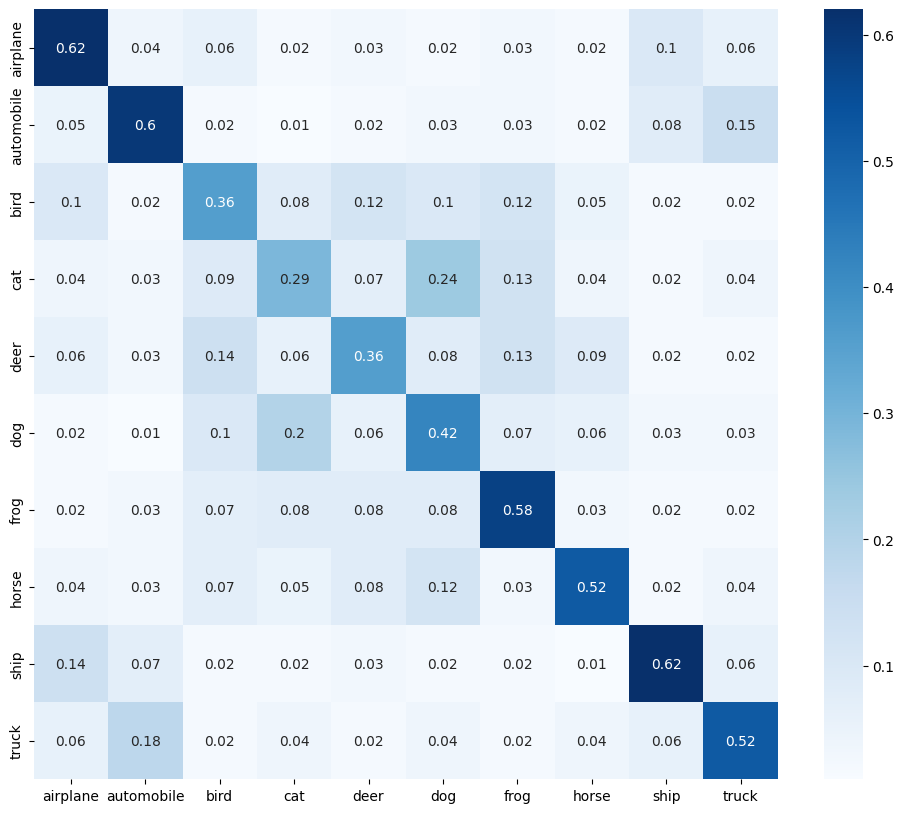

In [18]:
#@title Test set results
#@markdown Visualization of the confusion matrix. On the vertical axis are the real labels,
#@markdown on the horizontal axis are the predicted labels. 
#@markdown The overall accuracy of the model should be around ~0.45-0.5.

acc, pred = solver.check_accuracy(data['X_test'], data['y_test'], num_samples=10000)
y_pred = pred['y_pred']
print('#########################################')
print('Overall Accuracy on the test set: ', acc)
print('#########################################')

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
# sns heatmap because plt.matshow has bugs with setting ticklabels

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
conf_mat = confusion_matrix(y_true= data['y_test'], y_pred=y_pred)
conf_mat = conf_mat/1000
conf_mat = np.round(conf_mat,2)

fig = plt.figure(figsize=(12, 10))
heatmap(conf_mat, cmap="Blues", annot=True,annot_kws={"size": 10}, xticklabels=names, yticklabels=names)
plt.show()

### 2.2.1 Browse the Test Set Predictions of your model
Below you can insert different image indices `img_idx` and get the associated input image and a bar chart with ground truth and prediction. Your test set consists of 10,000 examples, so integers in the intervall $[0,9999]$ are valid.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/tmp/ipykernel_72545/1692871404.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+names+[''])


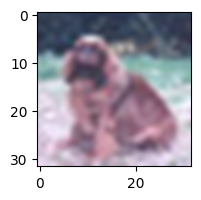

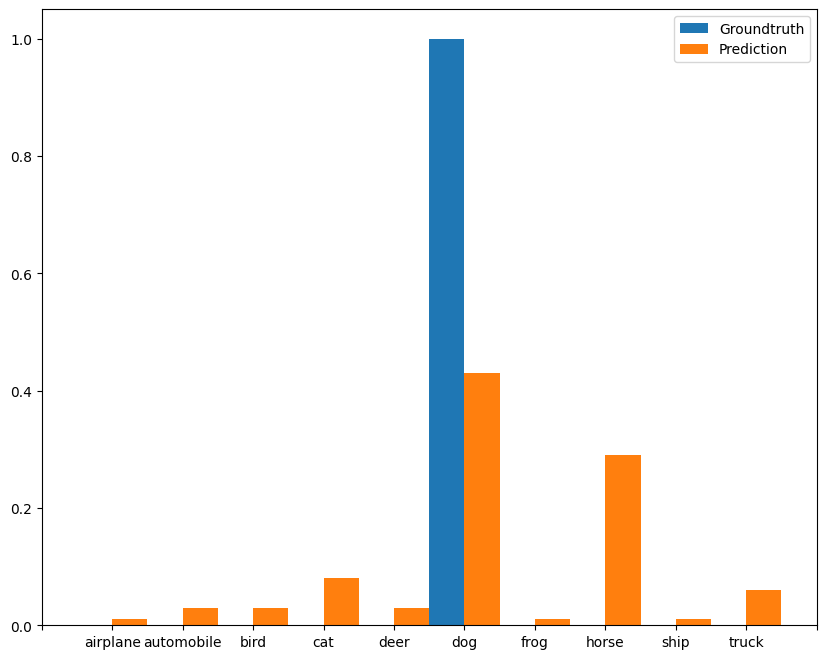

In [19]:
img_idx = 101

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def show_prediction(image_idx):
    img = (np.transpose(data['X_test'][image_idx], [1,2,0])/255)+0.5
    scores = np.transpose(pred['scores'])
    scores = np.round(softmax(scores[image_idx]),2)
    gt = np.zeros(10)
    gt[data['y_test'][image_idx]]=1

    plt.figure(figsize = (2,2))
    plt.imshow(img, interpolation='lanczos')
    names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    x_axis = np.arange(len(names))

    fig, ax = plt.subplots(figsize=(10,8))
    width = 0.5 
    rects1 = ax.bar(x_axis-width/2, gt, 0.5, label='Groundtruth')
    rects1 = ax.bar(x_axis+width/2, scores, 0.5, label='Prediction')
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.set_xticklabels(['']+names+[''])
    plt.legend()
    plt.show()
    return None

show_prediction(img_idx)

# 3 Qualitative Analysis of Predictions
<a id="Qualitative_Analysis"></a>
Last but not least, (1) find the 50 images with worst results and plot all these images, (2) find the 50 images with best results and plot them all, (3) speculate why the bad ones are not classified successfully (do they share some properties that well-classified images don't have?), and (4) brainstorm about potential modifications to the classifier which could help get the bad ones right. For (3) and (4), no answer is the only wrong answer :)

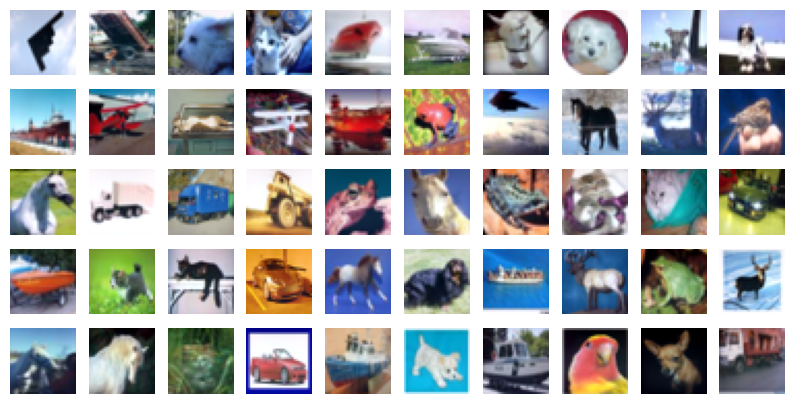

In [20]:
N = data['X_test'].shape[0]

# calculate softmaxes of the predicitons
x = pred['scores'].T
x = x - np.max(x, axis=1, keepdims=True)
p = np.exp(x)
sum = np.sum(p, axis=1, keepdims=True)
pred_soft = p / sum

# get the predicted probabilty of the correct class
y_test = data['y_test']
correct_prob = pred_soft[range(N), y_test]

# (1) find 50 worst images and plot them
worst_inds = np.argpartition(correct_prob, 50)[:50] # get the indices of the 50 worst images
plt.figure(figsize=(10,5))
for i, image_idx in enumerate(worst_inds):
    plt.subplot(5, 10, i+1)
    img = (np.transpose(data['X_test'][image_idx], [1,2,0])/255)+0.5
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

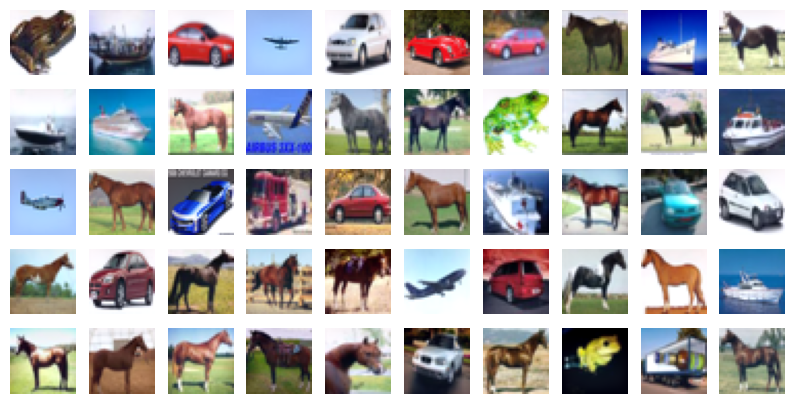

In [21]:
# (2) find 50 best images and plot them
best_inds = np.argpartition(correct_prob, -50)[-50:] # get the indices of the 50 best images
plt.figure(figsize=(10,5))
for i, image_idx in enumerate(best_inds):
    plt.subplot(5, 10, i+1)
    img = (np.transpose(data['X_test'][image_idx], [1,2,0])/255)+0.5
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

### Answer 3.3

Some have wierd frames like the red car in the last row.
Others have unchararistic backgrounds like animals with blue backgrounds. 
And some are probably not very well represented in the training data like the B2 bomber as an airplane.


### Answer 3.4

Maybe some sort of regularization.
